In [1]:
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.integrate import quad

import pyccl as ccl

loading modules...


In [2]:
import camb
from camb import model, initialpower


# Set cosmological parameters
params = camb.set_params(H0=67.01904, ombh2=0.02216571, omch2=0.1202944, omk=0, tau=0.06018107, YHe=0.2453006, w=-1.0, wa=0, nt=-0/8.0, nrun=0,\
                    pivot_scalar=0.05, pivot_tensor=0.05, )
params.omegan = 0.0006451439 / (67.01904**2 / 100**2)  # Convert omnuh2 to omegan

# Set dark energy parameters
params.set_dark_energy(w=-1.0)

# Set initial power spectrum parameters
params.InitPower.set_params(As=2.119631e-9, ns=0.9636852, nrun=0.0)

# Set accuracy and lmax parameters
params.set_for_lmax(lmax=7000, lens_potential_accuracy=10, max_eta_k=100000)

# Set additional accuracy parameters
params.Accuracy.AccuracyBoost = 2
params.Accuracy.lAccuracyBoost = 2
params.Accuracy.HighAccuracyDefault = True


# Set other parameters
params.WantCls = True
params.Want_CMB = True
params.WantTransfer = False
params.WantTensors = False
params.WantVectors = False
params.WantScalars = True
params.NonLinear = model.NonLinear_both
params.DoLensing = True
params.Alens = 1.0
params.DoLateRadTruncation = True
params.WantDerivedParameters = True

# Reionization settings
params.Reion.Reionization = True
params.Reion.use_optical_depth = True
params.Reion.optical_depth = 0.06018107
params.Reion.delta_redshift = 0.5
params.Reion.fraction = -1
params.Reion.Helium_redshift = 3.5
params.Reion.Helium_delta_redshift = 0.5
params.Reion.Helium_redshiftstart = 5.0




# Neutrino settings
# Ensure other parameters are correctly set
params.TCMB = 2.7255
params.YHe = 0.2453006
params.num_massless_neutrinos = 2.03066666667
params.num_massive_neutrinos = 1
params.nu_mass_fractions = [1.0]
params.nu_mass_degeneracies = [1.01533333333]
params.share_delta_neff = False

# 计算结果
results = camb.get_results(params)

# 打印一些结果以验证
print('Omega_m:', params.omegam)
print('H0:', params.H0)


Omega_m: 0.3186092143903546
H0: 67.01904


In [3]:
def z2a(z):
    return 1/(1+z)

def a2z(a):
    return 1/a-1


lmax = 6143 
ls = np.arange(0, lmax+1)
zs = np.linspace(1e-4,15,600)

Hzs = results.hubble_parameter(zs)  # Km/s/Mpc
H0 = 67.01904  # Km/s/Mpc

h = H0/100

c = 299792.458   # Km/s


#ombh2=0.02216571
#omch2=0.1202944
#Omega_m = (ombh2+omch2)/h**2

Omega_m = params.omegam
Omega_c = params.omegac
Omega_b = params.omegab
Omega_k = 0
Omega_g = 0

A_s = 2.119631e-9
n_s = 0.9636852

Neff = 2.03066666667

extra_params = {'kmax' : 20, 'lmax' : 7000}

cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=n_s, sigma8=None, A_s=A_s, Omega_k=0.0, Omega_g=Omega_g, Neff=None, m_nu=0.0, mass_split='single', w0=-1.0, wa=0.0, T_CMB=2.7255, T_ncdm=0.71611, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryonic_effects=None, mg_parametrization=None, extra_parameters=extra_params)


In [58]:
chi_values = ccl.comoving_radial_distance(cosmo, z2a(zs))
chi_star = ccl.comoving_radial_distance(cosmo, z2a(1090))

ks = np.linspace(1e-4, 20, 1000000)
pkz = ccl.nonlin_matter_power(cosmo, ks, z2a(zs))

In [59]:
pkz2 = ccl.linear_matter_power(cosmo, ks, z2a(zs))

In [63]:
(pkz[0]-pkz2[0])

[-0.21573398 -0.30840458 -0.41710681 ...  3.00683942  3.00683291
  3.00682639]


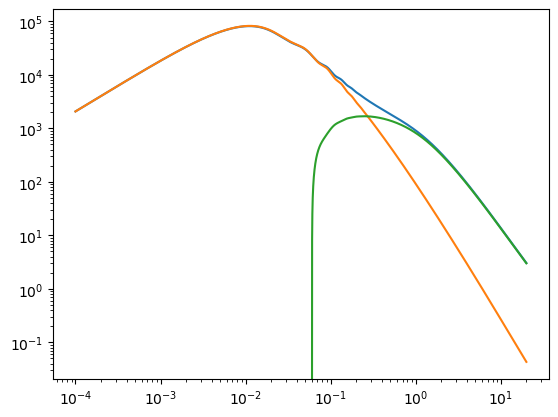

In [62]:
plt.loglog(ks, pkz[0], label='nonlinear')
plt.loglog(ks, pkz2[0], label='linear')
plt.loglog(ks, pkz[0]-pkz2[0], label='diff')

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def determine_kmax(ls, chi_values):
    """Using Limber approximation to calculate ks and return a 3D array."""
    
    # Initialize an empty 3D array for storing (ls, chi_values, ks)
    ks_array = np.zeros((len(ls), len(chi_values), 3))  # Shape: (len(ls), len(chi_values), 3)
    
    for i, l in enumerate(ls):
        for j, chi in enumerate(chi_values):
            ks = l / chi
            ks_array[i, j] = [l, chi, ks]
    
    return ks_array

ks_findmax = determine_kmax(ls, chi_values)

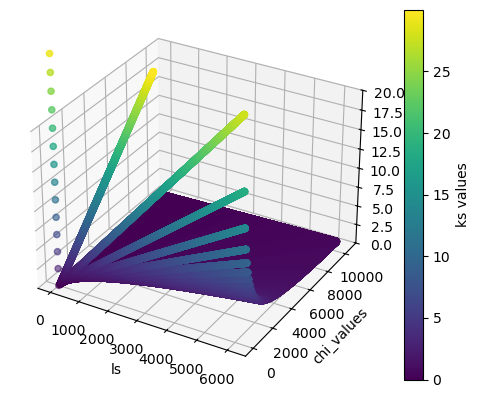

In [6]:
# Example data, replace with your actual data
l_vals = ks_findmax[:, :, 0].flatten()
chi_vals = ks_findmax[:, :, 1].flatten()
ks_vals = ks_findmax[:, :, 2].flatten()

# Mask to filter out ks_vals greater than or equal to 100
mask = ks_vals < 30
l_vals_filtered = l_vals[mask]
chi_vals_filtered = chi_vals[mask]
ks_vals_filtered = ks_vals[mask]

# Create a new figure
fig = plt.figure()

# Add 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
scatter = ax.scatter(l_vals_filtered, chi_vals_filtered, ks_vals_filtered, c=ks_vals_filtered, cmap='viridis')

# Setting labels for axes
ax.set_xlabel('ls')
ax.set_ylabel('chi_values')
ax.set_zlabel('ks')

# Set limits for ks axis
ax.set_zlim(0, 20)

# Add a color bar which maps values to colors
fig.colorbar(scatter, ax=ax, label='ks values')

plt.show()

In [7]:
def find_nearest(data,x):    
    kh_tree = cKDTree(data.reshape(-1, 1))

    # 查找 k_values 在 kh 中的最近邻
    distances, indices = kh_tree.query(x.reshape(-1, 1))

    # 打印结果
    #for k, idx in zip(x, indices):
            #print(f'k = {k:.6e}, closest index in kh = {idx}, k[idx] = {data[idx]:.6e}, relavant error = {np.abs(k/data[idx]-1):.6e}')

    return indices 

In [8]:
np.shape(pkz)

(600, 1000000)

In [9]:
#Method1: Using approximation k to get the Pk

Plzs = np.zeros((len(ls), len(zs)))

# Precompute k_lz matrix
k_lz_matrix = np.outer(ls, 1 / chi_values)  # Shape (len(ls), len(zs))

# Flatten k_lz_matrix for efficient querying
k_lz_flat = k_lz_matrix.flatten()

# Find the nearest k_lz indices in kh_nonlin
k_lz_indices_flat = find_nearest(ks, k_lz_flat)

# Reshape k_lz_indices back to the shape of k_lz_matrix
k_lz_indices = k_lz_indices_flat.reshape(k_lz_matrix.shape)

# Extract the power spectrum values for all (l, z) pairs
# We need to create a matrix of indices to properly index pk_nonlin
for idx2 in range(len(zs)):
    P_lz_matrix = pkz[idx2, k_lz_indices[:, idx2]]
    Plzs[:, idx2] = P_lz_matrix

In [10]:
#Method2: Using Exact k to get the Pk (slower, with for loop)
#Plzs = np.zeros((len(ls), len(zs)))



In [11]:
from scipy.integrate import quadrature

def cal_LSS_power(W1, W2, Hzs, chizs, Plzs, zs, lmax, limit=1000):
    l = np.arange(lmax)
    z_min = np.min(zs)
    z_max = np.max(zs)
    cl = np.zeros(lmax)
    for l in range(lmax):
        inte_kernal = Hzs /c /chizs**2 * W1 * W2 * Plzs[l,:]
        Pz_interp = interp1d(zs, inte_kernal, kind='cubic', fill_value="extrapolate")
        integral_result, error = quad(Pz_interp, z_min, z_max, epsabs=1e-8, epsrel=1e-8, limit=limit)
        def integrand(z):
            return Pz_interp(z)
        #integral_result, error = quadrature(integrand, z_min, z_max, tol=1.49e-8, rtol=1.49e-8, maxiter=100000)
        cl[l] = integral_result
        #print(integral_result/error)
    return cl

In [12]:
#Window Function of lensing convergence
norm = 1/np.max(1.5 * (Omega_m/c) * (H0**2/Hzs) * (1+zs) * (chi_values) * (1-chi_values/chi_star))
Wkz_k = 1.5 * (Omega_m/c) * (H0**2/Hzs) * (1+zs) * (chi_values) * (1-chi_values/chi_star)     #* norm

In [13]:
#Power of lensing convergence
clkk = cal_LSS_power(Wkz_k, Wkz_k, Hzs, chi_values, Plzs, zs, lmax+1)
factor = ls*(ls+1)/2
dlpp = clkk *2 /np.pi

In [14]:
dlpp

array([4.74655362e-09, 2.65506429e-08, 4.33508010e-08, ...,
       3.77881496e-10, 3.77784900e-10, 3.77686319e-10])

(1, 6000)

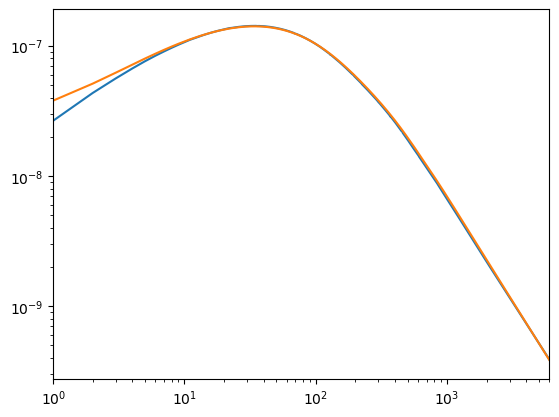

In [15]:
from lenspyx.utils import camb_clfile
clpp_planck = camb_clfile('/root/download/plancklens/plancklens/data/cls/FFP10_wdipole_lenspotentialCls.dat',lmax)['pp']   #l,TT,EE,BB,TE,PP,TP,EP
dlpp_planck = clpp_planck * (ls*(ls+1))**2 / (2*np.pi)

plt.loglog(ls, dlpp, label='pp')
plt.loglog(ls, dlpp_planck, label='planck')


plt.xlim(1, 6000)

In [16]:
#Window Function of CIB
z_c = 2
sigma_z = 2

def f_ref(zs, nu=353e9, nu_ref=4955e9):
    h = 6.62607015e-34
    k = 1.380649e-23
    T = 34
    beta = alpha = 2

    znu = (1+zs) * nu
    result = np.where(
        znu <= nu_ref,
        (np.exp(h * znu / k / T) - 1)**(-1) * znu **(beta + 3),
        (np.exp(h * nu_ref / k / T) - 1)**(-1) * nu_ref **(beta + 3) * (znu / nu_ref)**(-alpha)
    )
    return result

def normalize_W(W_raw, z, z_min, z_max):
    W_interp = interp1d(zs, W_raw, kind='cubic', fill_value="extrapolate")
    integral, _ = quad(W_interp, z_min, z_max, epsabs=1e-8, epsrel=1e-8, limit=1000)
    b = 1 / integral
    return b

def get_Wkz_i(zs,nu,):    
    #b_c = 1/np.max(chi_values**2 /Hzs /(1+zs)**2 * np.exp(-(zs-z_c)**2/2/sigma_z**2) * f_ref(zs,nu))
    b_c = normalize_W(chi_values**2 /Hzs /(1+zs)**2 * np.exp(-(zs-z_c)**2/2/sigma_z**2) * f_ref(zs,nu), zs, np.min(zs), np.max(zs),)
    Wkz_i = b_c * chi_values**2 /Hzs /(1+zs)**2 * np.exp(-(zs-z_c)**2/2/sigma_z**2) * f_ref(zs,nu)
    return Wkz_i

Wkz_i = get_Wkz_i(zs,nu=353e9,) * 0.5

In [17]:
def CIB_shot_noise(nu1,nu2):
    """
    These data are from Planck 2013 results. XXX. Cosmic infrared background measurements and implications for star formation Tab.6 and Tab.7.
    For nu1 and nu2, both radio galaxy shot noise and star-forming galaxy shot noise power are (flat power-spectra) in Jy^2/sr.
    """
    C_d_shot = {
    (3000, 3000): (10064, 2013),
    (3000, 857): (4427, 885),
    (3000, 545): (1525, 305),
    (3000, 353): (434, 87),
    (3000, 217): (96, 19),
    (3000, 143): (26, 5),
    (3000, 100): (11, 2),
    (857, 857): (5628, 1126),
    (857, 545): (2655, 531),
    (857, 353): (913, 183),
    (857, 217): (216, 43),
    (857, 143): (56, 11),
    (857, 100): (20, 4),
    (545, 545): (1454, 291),
    (545, 353): (543, 109),
    (545, 217): (135, 27),
    (545, 143): (35, 7),
    (545, 100): (12, 2),
    (353, 353): (225, 45),
    (353, 217): (59, 12),
    (353, 143): (15, 3),
    (353, 100): (5.4, 1.1),
    (217, 217): (16, 3),
    (217, 143): (4.3, 0.9),
    (217, 100): (1.5, 0.3),
    (143, 143): (1.2, 0.2),
    (143, 100): (0.42, 0.08),
    (100, 100): (0.15, 0.03)
    }
    C_r_shot = {
    (857, 857): (4.28, 0.90),
    (857, 545): (2.28, 0.56),
    (857, 353): (2.10, 0.53),
    (857, 217): (1.53, 0.46),
    (857, 143): (2.38, 0.58),
    (857, 100): (2.73, 0.64),
    (545, 545): (2.86, 0.70),
    (545, 353): (2.59, 0.63),
    (545, 217): (1.92, 0.56),
    (545, 143): (2.86, 0.68),
    (545, 100): (3.24, 0.73),
    (353, 353): (3.28, 0.82),
    (353, 217): (2.40, 0.70),
    (353, 143): (3.57, 0.82),
    (353, 100): (4.02, 0.90),
    (217, 217): (3.12, 0.79),
    (217, 143): (3.68, 0.99),
    (217, 100): (4.31, 1.07),
    (143, 143): (6.05, 1.47),
    (143, 100): (6.47, 1.39),
    (100, 100): (8.47, 1.97)
    }
    key = (nu1/1e9,nu2/1e9) if nu1 > nu2 else (nu2/1e9,nu1/1e9)
    if nu1/1e9 != 3000 and nu2/1e9 != 3000:
        return  C_d_shot[key][0] + C_r_shot[key][0] 
    else:
        return C_r_shot[key][0] 
 

In [18]:
clii_shot = CIB_shot_noise(353e9,353e9) / 1e12

In [19]:
clii_shot

2.2828e-10

(2.0, 2000.0)

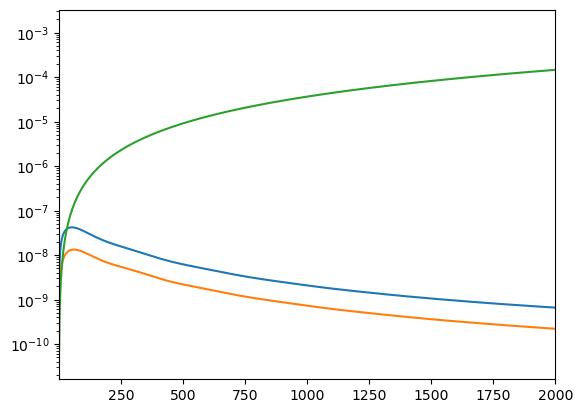

In [20]:
# #Power of CIB
zmax_i = np.int((len(zs)-1)*0.3)

clii = cal_LSS_power(Wkz_i[:zmax_i], Wkz_i[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
factor = ls*(ls+1)/2
dlii = clii * factor**2 * 2 /np.pi

clik = cal_LSS_power(Wkz_i[:zmax_i], Wkz_k[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
factor = ls*(ls+1)/2
dlip = clii * factor /np.pi

dlii_shot = clii_shot * factor /np.pi


plt.semilogy(ls,clik,label='$L^2(L+1)^2C_L^{IK}/2/\pi$')
plt.semilogy(ls,clii,label='$L^2(L+1)^2C_L^{II}/2/\pi$')
plt.semilogy(ls,dlii_shot,label='$L^2(L+1)^2C_L^{II}/2/\pi$')

#plt.ylim(1e-9,1e-6)
plt.xlim(2,2000)

Text(0, 0.5, '$\\rho_{\\ell}$')

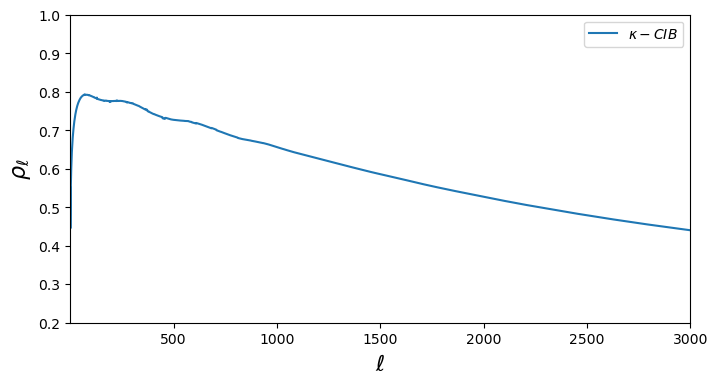

In [21]:
plt.figure(figsize=(8,4))

rho_ik = clik / np.sqrt(clkk*(clii+clii_shot))
plt.plot(ls,rho_ik,label='$\kappa-CIB$')

plt.legend()
plt.ylim(0.2,1)
plt.xlim(1,3000)
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel(r'$\rho_{\ell}$',fontsize=16)

In [22]:
np.savetxt('Kappa_CIB_power.txt',[ls,clkk,clik,clii])

In [23]:
fs = np.array([100e9,143e9,217e9,353e9,545e9,857e9])
rhos = []
for f in fs:
    Wkz_is = get_Wkz_i(zs,nu=f,)
    clii = cal_LSS_power(Wkz_is[:zmax_i], Wkz_is[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
    clik = cal_LSS_power(Wkz_is[:zmax_i], Wkz_k[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
    rhos.append(clik/(clii*clkk)**0.5)

(60.0, 2000.0)

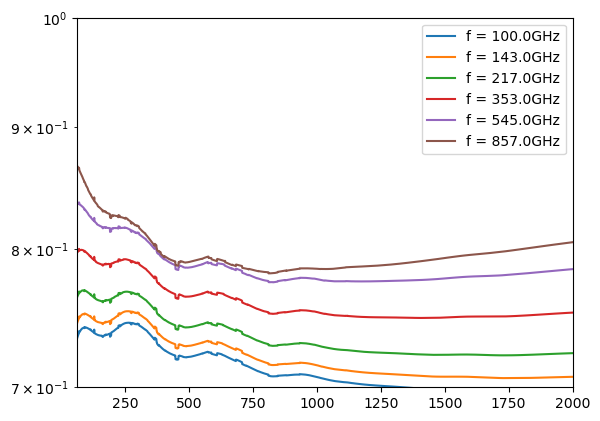

In [24]:
for i, f in enumerate(fs):
    plt.plot(rhos[i], label=f"f = {f/1e9}GHz")

# 添加图例和显示图形
plt.legend()
plt.semilogy()
plt.ylim(0.7,1)
plt.xlim(60,2000)

In [25]:
# Window Function of galaxy number density (Euclid, LSST, SKA, etc)
from scipy.special import erfc
from scipy.special import gamma


def bias_g(z,flag):
    if flag == 'Euclid':
        bz = (1 + z)**0.5
    elif flag == 'LSST':
        bz = 1 + 0.84*z
    elif flag == 'WFIRST':
        bz = 1 + 0.84*z
    elif flag == 'SKA':     # b3,b2,b1,b0 查看TRABEL III. of PhysRev.93.043527
        bz = 0.94 + 0.43*z + 0.18*z**2 -0.0019*z**3
    return bz

def bin_zs_sequences(zs, bin_idx):
    """
    Splits the `zs` array into bins according to the indices provided in `bin_idx`.
    
    Parameters:
        zs (array-like): The original array of `zs` values.
        bin_idx (array-like): The array of indices that define the bin boundaries.
    
    Returns:
        list of arrays: A list where each element is an array of `zs` values for a bin.
    """
    # Initialize an empty list to store the zs sequences for each bin
    bins = []
    
    # Loop through the bin indices and slice the zs array accordingly
    for i in range(len(bin_idx) - 1):
        bins.append(zs[bin_idx[i]:bin_idx[i+1]])
    
    # Include the last bin from the last index to the end of zs
    bins.append(zs[bin_idx[-1]:])
    
    return bins

def dist_g(zmin,zmax,z,sigma_z):
    sigma_zs = (1+z) * sigma_z
    return 0.5 * (erfc((zmin-z)/2**0.5/sigma_zs) - erfc((zmax-z)/2**0.5/sigma_zs) )

def cal_galaxy_window(zs, Hzs, flag, bin_bound = None):
    if flag == 'Euclid':
        alpha = 2
        beta = 1.5
        sigma_z = 0.05
        z0 = 0.9 / 2**0.5
        if bin_bound is None:
            bin_bound = np.array([0, 1, 1.5, 2.0, 2.5, 6.0])
            #bin_bound = np.array([0,1.0]) 
        
    elif flag == 'LSST':
        alpha = 2
        beta = 1
        sigma_z = 0.05
        z0 = 0.311
        if bin_bound is None:
            #bin_bound = np.array([0, 0.5, 1.0, 2.0, 3.0, 6.0])
            bin_bound = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.3, 1.7, 2.0, 2.5, 6.0])
            #bin_bound = np.array([0,0.5,1.0]) 

    elif flag == 'WFIRST':
        alpha = 2
        beta = 1.02
        sigma_z = 0.05
        z0 = 0.6
        if bin_bound is None:
            bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0])
            #bin_bound = np.array([0,6.0])    

    elif flag == 'SKA':
        alpha = 2
        beta = 1.11
        sigma_z = 0.05
        z0 = 0.63    # calculated with zm = gamma()/gamma() * z0
        if bin_bound is None:
            bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0])
            #bin_bound = np.array([0,6.0])  

    bin_idx = find_nearest(zs,bin_bound)
    zs_binned = bin_zs_sequences(zs, bin_idx)
    Hzs_binned = bin_zs_sequences(Hzs, bin_idx)

    # The mean redshift
    zm = gamma((alpha+2)/beta) / gamma((alpha+1)/beta) * z0
    
    def der(z,Hz,zmin,zmax):
        return beta * Hz / gamma((alpha+1)/beta) * (z**alpha / z0 ** (alpha+1)) * np.exp(-(z/z0)**beta) * dist_g(zmin,zmax,z,sigma_z) / Hz #* c

    Wkz_gs = []
    inte_kernals = []
    for i in range(len(bin_idx) - 1):
        zmin = np.min(zs_binned[i])
        zmax = np.max(zs_binned[i])

        inte_kernal = der(zs,Hzs,zmin,zmax)
        Wkz_gs.append(bias_g(zs,flag) * inte_kernal )
        inte_kernals.append(inte_kernal)
    return zs_binned, Wkz_gs

def shot_noises(flag):  
    """
    The white shot noise for galaxy auto-power spectrum. Add this to the galaxy auto-power spectrum.
    """
    arcmin_to_sr = lambda arcmin: (arcmin * (np.pi / 180 / 60))**2 

    if flag == 'Euclid':
        n_g = 30
        
    elif flag == 'LSST':    
        n_g = 40

    elif flag == 'WFIRST':     
        n_g = 45

    elif flag == 'SKA':
        n_g = 0.0001         #射电,有点大，暂时不用了

    return arcmin_to_sr(1/n_g)

In [26]:
import numpy as np
from scipy.special import erfc, gamma

class GalaxySurvey:
    """
    A class contains used to calculate the window function of galaxy number density, and the shot noise for galaxy auto-power.
    flag: the name of the survey
    bin_bound: the boundary of each tomographic redshift bins
    """
    def __init__(self, flag, bin_bound):
        self.flag = flag
        self.set_survey_parameters()
        self.bin_bound = bin_bound

    def set_survey_parameters(self):
        if self.flag == 'Euclid':
            self.alpha = 2
            self.beta = 1.5
            self.sigma_z = 0.05
            self.z0 = 0.9 / 2**0.5
            #self.bin_bound = np.array([0, 1, 1.5, 2.0, 2.5, 6.0])
            self.n_g = 30
            self.fsky = 0.436

        elif self.flag == 'LSST':
            self.alpha = 2
            self.beta = 1
            self.sigma_z = 0.05
            self.z0 = 0.311
            #self.bin_bound = np.array([0, 0.5, 1.0, 2.0, 3.0, 6.0])
            #self.bin_bound = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.3, 1.7, 2.0, 2.5, 6.0])
            self.n_g = 40
            self.fsky = 0.364

        elif self.flag == 'WFIRST':
            self.alpha = 2
            self.beta = 1.02
            self.sigma_z = 0.05
            self.z0 = 0.6
            #self.bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0])
            self.n_g = 45
            self.fsky = 0.053

        elif self.flag == 'SKA':
            self.alpha = 2
            self.beta = 1.11
            self.sigma_z = 0.05
            self.z0 = 0.63    # calculated with zm = gamma()/gamma() * z0
            #self.bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0])
            self.n_g = 0.0001  # 射电,有点大，暂时不用了
            self.fsky = 0.7  #来自ChatGPT,不确定，未查到数据

        # Calculate mean redshift
        self.zm = gamma((self.alpha + 2) / self.beta) / gamma((self.alpha + 1) / self.beta) * self.z0

    def bias_g(self, z):
        if self.flag == 'Euclid':
            return (1 + z) ** 0.5
        elif self.flag == 'LSST' or self.flag == 'WFIRST':
            return 1 + 0.84 * z
        elif self.flag == 'SKA':
            return 0.94 + 0.43 * z + 0.18 * z ** 2 - 0.0019 * z ** 3

    def bin_zs_sequences(self, zs):
        """
        Splits the `zs` array into bins according to the indices provided in `bin_idx`.
        
        Parameters:
            zs (array-like): The original array of `zs` values.
            bin_idx (array-like): The array of indices that define the bin boundaries.
        
        Returns:
            list of arrays: A list where each element is an array of `zs` values for a bin.
        """
        bin_idx = find_nearest(zs, self.bin_bound)
        bins = []
        for i in range(len(bin_idx) - 1):
            bins.append(zs[bin_idx[i]:bin_idx[i + 1]])
        bins.append(zs[bin_idx[-1]:])
        return bins


    def dist_g(self, zmin, zmax, z):
        sigma_zs = (1 + z) * self.sigma_z
        return 0.5 * (erfc((zmin - z) / np.sqrt(2) / sigma_zs) - erfc((zmax - z) / np.sqrt(2) / sigma_zs))

    def cal_galaxy_window(self, zs, Hzs):
        bin_idx = find_nearest(zs, self.bin_bound)
        zs_binned = self.bin_zs_sequences(zs)
        Hzs_binned = self.bin_zs_sequences(Hzs)

        def der(z, Hz, zmin, zmax):
            return self.beta * Hz / gamma((self.alpha + 1) / self.beta) * \
                   (z ** self.alpha / self.z0 ** (self.alpha + 1)) * np.exp(-(z / self.z0) ** self.beta) * \
                   self.dist_g(zmin, zmax, z) / Hz

        Wkz_gs = []
        for i in range(len(bin_idx) - 1):
            zmin = np.min(zs_binned[i])
            zmax = np.max(zs_binned[i])
            inte_kernal = der(zs, Hzs, zmin, zmax)
            Wkz_gs.append(self.bias_g(zs) * inte_kernal)
        return zs_binned, Wkz_gs

    def shot_noises(self, zs):
        """
        The white shot noise for galaxy auto-power spectrum. Add this to the galaxy auto-power spectrum.
        """
        bin_idx = find_nearest(zs, self.bin_bound)
        zs_binned = self.bin_zs_sequences(zs)
        arcmin_to_sr = lambda arcmin: (arcmin * (np.pi / 180 / 60)) ** 2

        P_sn = []
        for i in range(len(bin_idx) - 1):
            zmin = np.min(zs_binned[i])
            zmax = np.max(zs_binned[i])
            n_gi_z = self.n_g * self.dist_g(zmin, zmax, zs)

            n_gi_z_interp = interp1d(zs, n_gi_z, kind='cubic', fill_value="extrapolate")
            integral_result, error = quad(n_gi_z_interp, np.min(zs), np.max(zs), epsabs=1e-8, epsrel=1e-8, limit=10000)

            n_gi = integral_result
            P_sn.append(arcmin_to_sr(1 / n_gi))
        return zs_binned, P_sn

In [27]:
LSST_survey = GalaxySurvey(flag='LSST', bin_bound = np.array([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 6.0]))
Euclid_survey = GalaxySurvey(flag='Euclid', bin_bound = np.array([0, 1, 1.5, 2.0, 2.5, 6.0]))
WFIRST_survey = GalaxySurvey(flag='WFIRST', bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0]))
SKA_survey = GalaxySurvey(flag='SKA', bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0]))


zs_binned, Wkz_gs_LSST_bin = LSST_survey.cal_galaxy_window(zs, Hzs,)
zs_binned, P_sn_LSST = LSST_survey.shot_noises(zs,)

zs_binned, Wkz_gs_Euclid_bin = Euclid_survey.cal_galaxy_window(zs, Hzs,)

zs_binned, Wkz_gs_WFIRST_bin = WFIRST_survey.cal_galaxy_window(zs, Hzs,)

zs_binned, Wkz_gs_SKA_bin = SKA_survey.cal_galaxy_window(zs, Hzs,)

In [28]:
Wkz_gs_LSST_tomo = np.sum(Wkz_gs_LSST_bin, axis=0)
Wkz_gs_Euclid_tomo = np.sum(Wkz_gs_Euclid_bin, axis=0)
Wkz_gs_WFIRST_tomo = np.sum(Wkz_gs_WFIRST_bin, axis=0)
Wkz_gs_SKA_tomo = np.sum(Wkz_gs_SKA_bin, axis=0)

In [29]:
LSST_survey = GalaxySurvey(flag='LSST', bin_bound = np.array([0,  6.0]))
Euclid_survey = GalaxySurvey(flag='Euclid', bin_bound = np.array([0,  6.0]))
WFIRST_survey = GalaxySurvey(flag='WFIRST', bin_bound = np.array([0,  6.0]))
SKA_survey = GalaxySurvey(flag='SKA', bin_bound = np.array([0,  6.0]))

zs_full, Wkz_gs_LSST = LSST_survey.cal_galaxy_window(zs, Hzs,)
zs_full, Wkz_gs_Euclid = Euclid_survey.cal_galaxy_window(zs, Hzs, )
zs_full, Wkz_gs_WFIRST = WFIRST_survey.cal_galaxy_window(zs, Hzs, )
zs_full, Wkz_gs_SKA = SKA_survey.cal_galaxy_window(zs, Hzs,)

In [30]:
def cut_Wg(Wg, threshold=1e-3):
    "Cut the Weight function of galaxy, very low value at high-z may cause round-off error."
    # Convert Wg to a numpy array if it's not already
    Wg = np.array(Wg)
    
    # Apply the threshold condition
    Wg_cut = np.where(Wg < threshold, 0, Wg)
    
    return Wg_cut

In [31]:
def norm_with_max(data):
    return data / np.max(data)

Wkz_gs_LSST = cut_Wg(norm_with_max(Wkz_gs_LSST)) * np.max(Wkz_gs_LSST)
Wkz_gs_Euclid = cut_Wg(norm_with_max(Wkz_gs_Euclid)) * np.max(Wkz_gs_Euclid)
Wkz_gs_WFIRST = cut_Wg(norm_with_max(Wkz_gs_WFIRST)) * np.max(Wkz_gs_WFIRST)
Wkz_gs_SKA = cut_Wg(norm_with_max(Wkz_gs_SKA)) * np.max(Wkz_gs_SKA)

Text(0, 0.5, 'W(z) (normalized)')

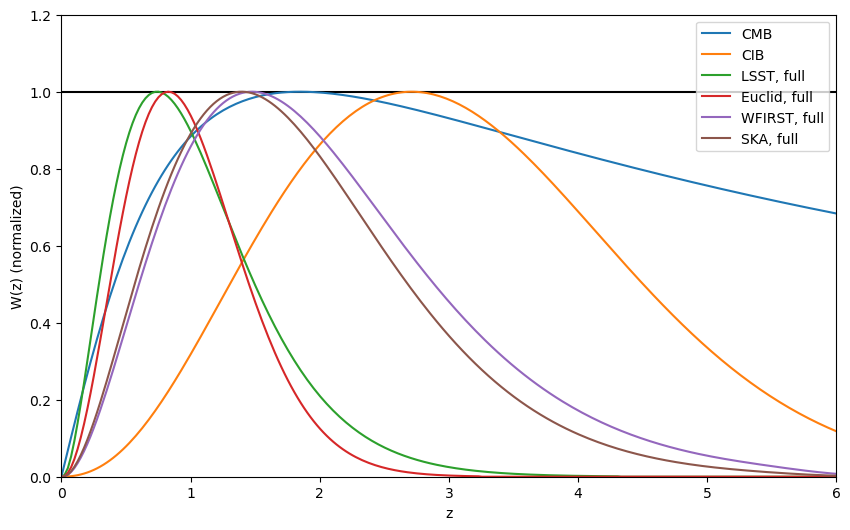

In [32]:
plt.figure(figsize=(10,6))
plt.hlines(1,0,6,'k')

plt.plot(zs,norm_with_max(Wkz_k),label='CMB')
plt.plot(zs,norm_with_max(Wkz_i),label='CIB')

plt.plot(zs,norm_with_max(Wkz_gs_LSST[0]),label='LSST, full')
plt.plot(zs,norm_with_max(Wkz_gs_Euclid[0]),label='Euclid, full')
plt.plot(zs,norm_with_max(Wkz_gs_WFIRST[0]),label='WFIRST, full')
plt.plot(zs,norm_with_max(Wkz_gs_SKA[0]),label='SKA, full')
plt.legend()
plt.ylim(0,1.2)
plt.xlim(0,6)
plt.xlabel('z')
plt.ylabel('W(z) (normalized)')

Text(0, 0.5, 'W(z)')

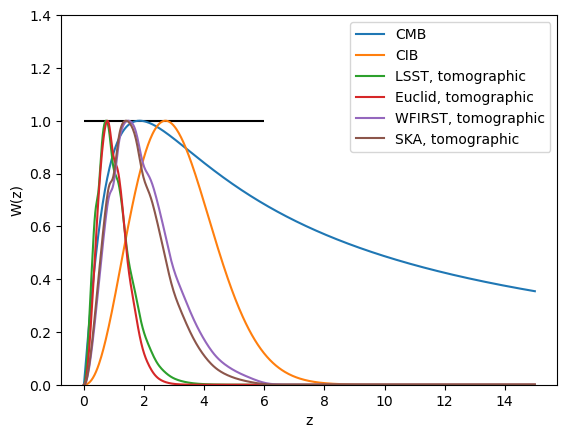

In [33]:
plt.hlines(1,0,6,'k')

plt.plot(zs,norm_with_max(Wkz_k),label='CMB')
plt.plot(zs,norm_with_max(Wkz_i),label='CIB')

plt.plot(zs,norm_with_max(Wkz_gs_LSST_tomo),label='LSST, tomographic')
plt.plot(zs,norm_with_max(Wkz_gs_Euclid_tomo),label='Euclid, tomographic')
plt.plot(zs,norm_with_max(Wkz_gs_WFIRST_tomo),label='WFIRST, tomographic')
plt.plot(zs,norm_with_max(Wkz_gs_SKA_tomo),label='SKA, tomographic')
plt.legend()
plt.ylim(0,1.4)
#plt.xlim(0,6)
plt.xlabel('z')
plt.ylabel('W(z)')

(0.0, 6.0)

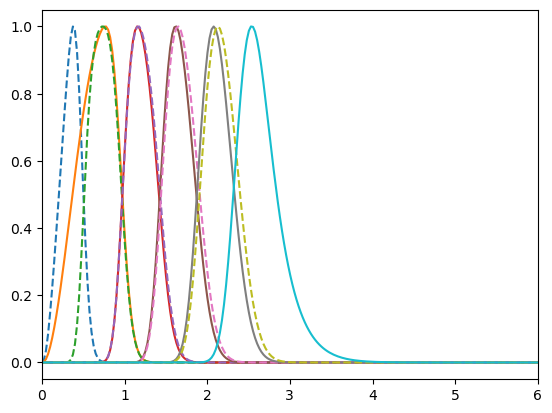

In [34]:
for i in range(len(zs_binned)-1):
    plt.plot(zs,norm_with_max(Wkz_gs_LSST_bin[i]),'--',label='LSST')
    plt.plot(zs,norm_with_max(Wkz_gs_Euclid_bin[i]),label='Euclid')

plt.xlim(0,6)
#plt.ylim(-1,1.5)

In [35]:
# #Power of galaxy surveys
factor = ls*(ls+1)/2
dlip = clii * factor /np.pi
zmax_g = np.int((len(zs)-1)*0.6)

# Full redshift bin
clkgs = []
clggs = []
cligs = []
surveys = ['Euclid','LSST','WFIRST','SKA']
Wkz_gs = [(Wkz_gs_Euclid[0]),(Wkz_gs_LSST[0]),(Wkz_gs_WFIRST[0]),(Wkz_gs_SKA[0]),]


for i,survey in enumerate(surveys):
    clkgs.append(cal_LSS_power(Wkz_gs[i][:zmax_g], Wkz_k[:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    cligs.append(cal_LSS_power(Wkz_gs[i][:zmax_g], Wkz_i[:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    clggs.append(cal_LSS_power(Wkz_gs[i][:zmax_g], Wkz_gs[i][:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1)) 


In [36]:
# Tomographic redshift bin (This is wrong, only for plot usage)

clkgs_tomo = []
clggs_tomo = []
cligs_tomo = []
surveys = ['Euclid','LSST','WFIRST','SKA']
Wkz_gs_tomo = [(Wkz_gs_Euclid_tomo),(Wkz_gs_LSST_tomo),(Wkz_gs_WFIRST_tomo),(Wkz_gs_SKA_tomo),]


for i,survey in enumerate(surveys):
    clkgs_tomo.append(cal_LSS_power(Wkz_gs_tomo[i][:zmax_g], Wkz_k[:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    cligs_tomo.append(cal_LSS_power(Wkz_gs_tomo[i][:zmax_g], Wkz_i[:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    clggs_tomo.append(cal_LSS_power(Wkz_gs_tomo[i][:zmax_g], Wkz_gs_tomo[i][:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    

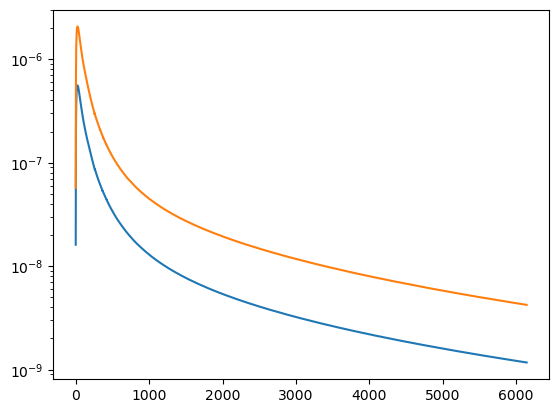

In [37]:
plt.semilogy(ls,clkgs[0],label='$L^2(L+1)^2C_L^{gK}/2/\pi$')
plt.semilogy(ls,clggs[0],label='$L^2(L+1)^2C_L^{gK}/2/\pi$')
plt.hlines(shot_noises('Euclid'),0,6071)


In [38]:
def get_norm(data):
    return 1 / np.max(data)

In [39]:
# Tomographic redshift bin for LSST (FIVE z-bin)

clkgs_LSST = []
clggs_LSST = []
cligs_LSST = []
surveys = ['bin1','bin2','bin3','bin4','bin5','bin6','bin7',]
#surveys = ['bin1','bin2','bin3','bin4','bin5','bin6','bin7','bin8','bin9','bin10',]
norm_LSST = get_norm(Wkz_gs_LSST_tomo)

Wkz_gs_LSST_tomo = [(Wkz_gs_LSST_bin[i]) for i in range(len(surveys))]


for i,survey in enumerate(surveys):
    clkgs_LSST.append(cal_LSS_power(Wkz_gs_LSST_tomo[i][:zmax_g], Wkz_k[:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    cligs_LSST.append(cal_LSS_power(Wkz_gs_LSST_tomo[i][:zmax_g], Wkz_i[:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))
    clggs_LSST.append(cal_LSS_power(Wkz_gs_LSST_tomo[i][:zmax_g], Wkz_gs_LSST_tomo[i][:zmax_g], Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:,:zmax_g], zs[:zmax_g], lmax+1))

In [40]:
factor = (Wkz_gs_LSST[0])/norm_with_max(Wkz_gs_LSST[0])

/tmp/ipykernel_2847/2910162981.py:1: RuntimeWarning: invalid value encountered in divide
  factor = (Wkz_gs_LSST[0])/norm_with_max(Wkz_gs_LSST[0])


Text(0, 0.5, 'W(z)')

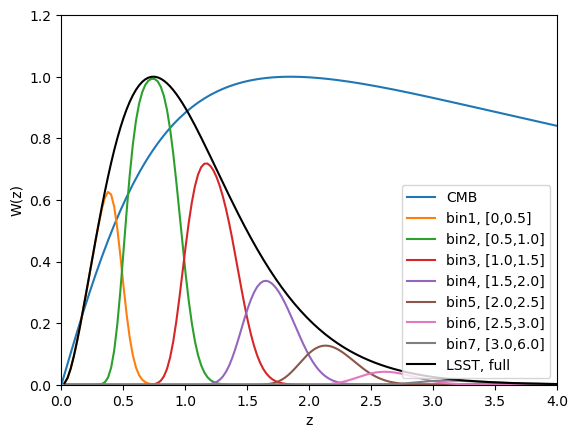

In [41]:
#surveys = ['bin1','bin2','bin3','bin4','bin5','bin6','bin7','bin8','bin9','bin10',]
#surveys = ['bin1','bin2','bin3','bin4','bin5',]
surveys = ['bin1, [0,0.5]','bin2, [0.5,1.0]','bin3, [1.0,1.5]','bin4, [1.5,2.0]','bin5, [2.0,2.5]','bin6, [2.5,3.0]','bin7, [3.0,6.0]',]
Wkz_gs_LSST_tomo = [(Wkz_gs_LSST_bin[i]) for i in range(len(surveys))]

plt.plot(zs,norm_with_max(Wkz_k),label='CMB')

for i,survey in enumerate(surveys):
    plt.plot(zs,Wkz_gs_LSST_tomo[i]/factor,label=f'{surveys[i]}')

plt.plot(zs,(Wkz_gs_LSST[0])/factor,'k',label='LSST, full')

plt.legend()
plt.ylim(0,1.2)
plt.xlim(0,4)
plt.xlabel('z')
plt.ylabel('W(z)')

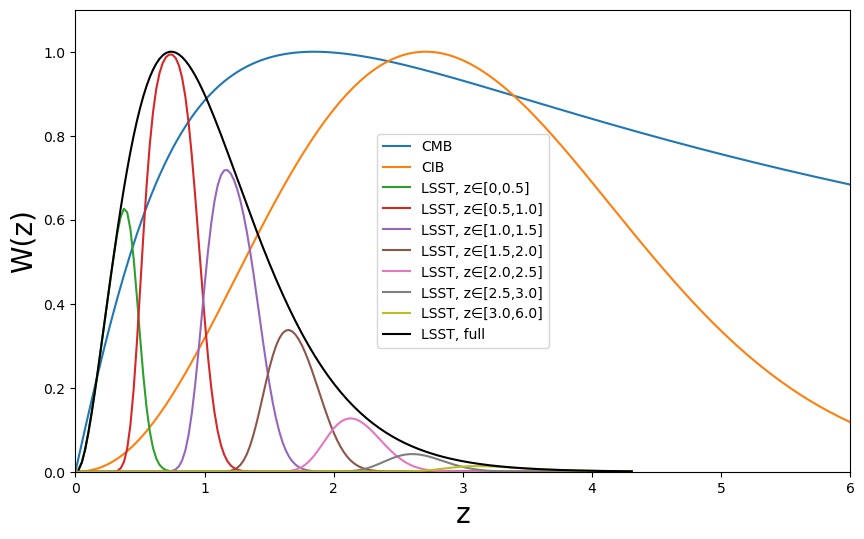

In [42]:
plt.figure(figsize=(10,6))
#plt.hlines(1,0,6,'k')

plt.plot(zs,norm_with_max(Wkz_k),label='CMB')
plt.plot(zs,norm_with_max(Wkz_i),label='CIB')

surveys = [
    'LSST, z∈[0,0.5]', 
    'LSST, z∈[0.5,1.0]', 
    'LSST, z∈[1.0,1.5]', 
    'LSST, z∈[1.5,2.0]', 
    'LSST, z∈[2.0,2.5]', 
    'LSST, z∈[2.5,3.0]', 
    'LSST, z∈[3.0,6.0]'
]
for i,survey in enumerate(surveys):
    plt.plot(zs,Wkz_gs_LSST_tomo[i]/factor,label=f'{surveys[i]}')

plt.plot(zs,(Wkz_gs_LSST[0])/factor,'k',label='LSST, full')

plt.legend()
plt.ylim(0,1.1)
plt.xlim(0,6)
plt.xlabel('z',fontsize=20)
plt.ylabel('W(z)',fontsize=20)
plt.savefig('weight_function.pdf',dpi=300)

In [43]:
def eff_rho(C_II, C_kappaI, lmax, nside, gal_cut=100):
    rho2 = np.zeros(lmax+1)
    num_of_tracers = len(C_II[:, 0, 0])

    C_II_inv = np.zeros(C_II.shape)
    for l in range(lmax):
        try:
            C_II_inv[:,:,l] = np.linalg.inv(C_II[:,:,l])
        except:
            pass

    for l in range(lmax+1):
        rho2[l] = np.einsum('i,ij,j->', C_kappaI[:,l], C_II_inv[:,:,l], C_kappaI[:,l]) / clkk[l]
    return rho2
"""
rho_eff2 = eff_rho(result_matrix[2:, 2:, :], np.array(clkgs_LSST), 6143, 2048, gal_cut=100)

plt.figure(figsize=(8,6))


rho_kg_LSST = clkgs[1] / np.sqrt(clkk*(clggs[1]+shot_noises('LSST')))
plt.plot(ls,rho_kg_LSST,label='$LSST \ full$')

plt.plot(ls,rho_eff2**0.5,label='$LSST \ tomographic \ binning$')

for i,survey in enumerate(surveys):
    rho_kg_Euclid = clkgs_LSST[i] / np.sqrt(clkk*(clggs_LSST[i]+P_sn_LSST[i])) 
    plt.plot(ls,rho_kg_Euclid,label=f'{surveys[i]}')
    #rho_kg_Euclid2 = clkgs_LSST[i] / np.sqrt(clkk*(clggs_LSST[i])) 
    #plt.plot(ls,rho_kg_Euclid2,'--',label=f'bin {i}')

plt.legend(loc='lower right')
plt.ylim(0,1)
plt.xlim(1,3000)
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel(r'$\rho_{\ell}$',fontsize=16)
"""

"\nrho_eff2 = eff_rho(result_matrix[2:, 2:, :], np.array(clkgs_LSST), 6143, 2048, gal_cut=100)\n\nplt.figure(figsize=(8,6))\n\n\nrho_kg_LSST = clkgs[1] / np.sqrt(clkk*(clggs[1]+shot_noises('LSST')))\nplt.plot(ls,rho_kg_LSST,label='$LSST \\ full$')\n\nplt.plot(ls,rho_eff2**0.5,label='$LSST \\ tomographic \\ binning$')\n\nfor i,survey in enumerate(surveys):\n    rho_kg_Euclid = clkgs_LSST[i] / np.sqrt(clkk*(clggs_LSST[i]+P_sn_LSST[i])) \n    plt.plot(ls,rho_kg_Euclid,label=f'{surveys[i]}')\n    #rho_kg_Euclid2 = clkgs_LSST[i] / np.sqrt(clkk*(clggs_LSST[i])) \n    #plt.plot(ls,rho_kg_Euclid2,'--',label=f'bin {i}')\n\nplt.legend(loc='lower right')\nplt.ylim(0,1)\nplt.xlim(1,3000)\nplt.xlabel('$\\ell$',fontsize=16)\nplt.ylabel(r'$\rho_{\\ell}$',fontsize=16)\n"

In [44]:
#np.savetxt('Euclid_power.txt',[ls,clkgs[0],cligs[0],clggs[0]])
#np.savetxt('LSST_power.txt',[ls,clkgs[1],cligs[1],clggs[1]])
#np.savetxt('WFIRST_power.txt',[ls,clkgs[2],cligs[2],clggs[2]])
#np.savetxt('SKA_power.txt',[ls,clkgs[3],cligs[3],clggs[3]])

In [45]:
nlpp = np.loadtxt('/root/Testarea/prototype/Foreground/LSS_tracer_simulation/nlpp_com.dat')[1]
nlkk = nlpp *(ls[:3072]*(ls[:3072]+1))**2*2/np.pi
rho_rec_th = clkk[:3072] / (clkk[:3072] * (clkk[:3072]+nlkk))**0.5

Text(0, 0.5, '$\\rho_{\\ell}$')

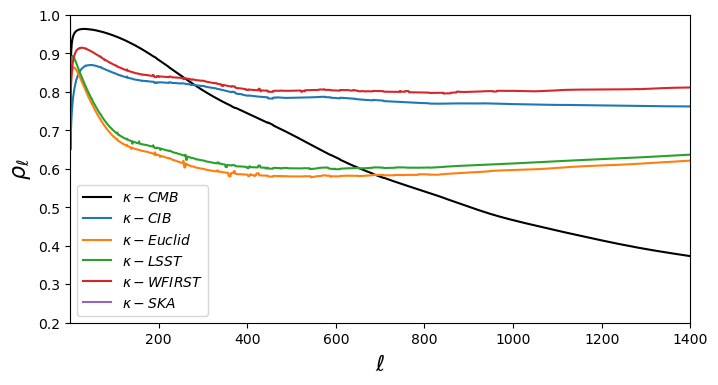

In [46]:
plt.figure(figsize=(8,4))


plt.plot(ls[:3072],rho_rec_th,'k',label='$\kappa-CMB$')

rho_ik = clik / np.sqrt(clkk*(clii+clii_shot))
plt.plot(ls,rho_ik,label='$\kappa-CIB$')

rho_kg_Euclid = clkgs[0] / np.sqrt(clkk*(clggs[0]+shot_noises('Euclid')))
plt.plot(ls,rho_kg_Euclid,label='$\kappa-Euclid$')

rho_kg_LSST = clkgs[1] / np.sqrt(clkk*(clggs[1]+shot_noises('LSST')))
plt.plot(ls,rho_kg_LSST,label='$\kappa-LSST$')

rho_kg_WFIRST = clkgs[2] / np.sqrt(clkk*(clggs[2]+shot_noises('WFIRST')))
plt.plot(ls,rho_kg_WFIRST,label='$\kappa-WFIRST$')

rho_kg_SKA = clkgs[3] / np.sqrt(clkk*(clggs[3]+shot_noises('SKA')))
plt.plot(ls,rho_kg_SKA,label='$\kappa-SKA$')
"""
rho_kg_Euclid_tomo = clkgs_tomo[0] / np.sqrt(clkk*(clggs_tomo[0]+shot_noises('Euclid')))
plt.plot(ls,rho_kg_Euclid_tomo,'--')

rho_kg_LSST_tomo = clkgs_tomo[1] / np.sqrt(clkk*(clggs_tomo[1]+shot_noises('LSST')))
plt.plot(ls,rho_kg_LSST_tomo,'--')

rho_kg_WFIRST_tomo = clkgs_tomo[2] / np.sqrt(clkk*(clggs_tomo[2]+shot_noises('WFIRST')))
plt.plot(ls,rho_kg_WFIRST_tomo,'--')

rho_kg_SKA_tomo = clkgs_tomo[3] / np.sqrt(clkk*(clggs_tomo[3]+shot_noises('SKA')))
plt.plot(ls,rho_kg_SKA_tomo,'--')
"""
"""
rho_kg_Euclid_tomo2 = clkgs_tomo2[0] / np.sqrt(clkk*clggs_tomo2[0])
plt.plot(ls,rho_kg_Euclid_tomo2,'.-')

rho_kg_LSST_tomo2 = clkgs_tomo2[1] / np.sqrt(clkk*clggs_tomo2[1])
plt.plot(ls,rho_kg_LSST_tomo2,'.-')

rho_kg_WFIRST_tomo2 = clkgs_tomo2[2] / np.sqrt(clkk*clggs_tomo2[2])
plt.plot(ls,rho_kg_WFIRST_tomo,'.-')

rho_kg_SKA_tomo2 = clkgs_tomo2[3] / np.sqrt(clkk*clggs_tomo2[3])
plt.plot(ls,rho_kg_SKA_tomo2,'.-')
"""

plt.legend()
plt.ylim(0.2,1)
plt.xlim(1,1400)
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel(r'$\rho_{\ell}$',fontsize=16)

In [47]:
Wkz_gs = [(Wkz_gs_Euclid[0]),(Wkz_gs_LSST[0]),(Wkz_gs_WFIRST[0]),(Wkz_gs_SKA[0]),]
tracers = {'kappa':Wkz_k, 'cib':Wkz_i, 'LSST': Wkz_gs[1], }

# 初始化一个6x6的结果数组
result_matrix = np.zeros((3, 3, lmax+1))

# 获取tracers的键名列表
tracer_keys = list(tracers.keys())

zmax_g = np.int((len(zs)-1)*1)
# 计算不同tracer组合之间的cal_LSS_power
for i, key1 in enumerate(tracer_keys):
    for j, key2 in enumerate(tracer_keys):
        W1 = tracers[key1][:zmax_g]
        W2 = tracers[key2][:zmax_g]
        result = cal_LSS_power(W1, W2, Hzs[:zmax_g], chi_values[:zmax_g], Plzs[:, :zmax_g], zs[:zmax_g], lmax+1)
        result_matrix[i, j, :] = result

In [48]:
#np.save('LSS_power_matrix.npy', result_matrix)

In [49]:
#Wkz_gs = [norm_with_max(Wkz_gs_Euclid[0]),norm_with_max(Wkz_gs_LSST[0]),norm_with_max(Wkz_gs_WFIRST[0]),norm_with_max(Wkz_gs_SKA[0]),]
tracers = {'kappa':Wkz_k, 'cib':Wkz_i, 'LSST1': Wkz_gs_LSST_tomo[0], 'LSST2': Wkz_gs_LSST_tomo[1], 'LSST3': Wkz_gs_LSST_tomo[2], 'LSST4': Wkz_gs_LSST_tomo[3],'LSST5':Wkz_gs_LSST_tomo[4],'LSST6':Wkz_gs_LSST_tomo[5],'LSST7':Wkz_gs_LSST_tomo[6]}

# 初始化一个6x6的结果数组
result_matrix = np.zeros((len(tracers.keys()), len(tracers.keys()), lmax+1))

# 获取tracers的键名列表
tracer_keys = list(tracers.keys())

zmax_k = np.int((len(zs)-1)*1)
zmax_g = np.int((len(zs)-1)*0.6)
zmax_i = np.int((len(zs)-1)*0.3)

# 计算不同tracer组合之间的cal_LSS_power
for i, key1 in enumerate(tracer_keys):
    for j, key2 in enumerate(tracer_keys):
        if (i==0 and j == 1) or (i==1 and j == 0) or (i==1 and j == 1):
            zmax = zmax_i
        elif i==0 and j==0:
            zmax = zmax_k
        else:
            zmax = zmax_g
        W1 = tracers[key1][:zmax]
        W2 = tracers[key2][:zmax]
        result = cal_LSS_power(W1[:zmax], W2[:zmax], Hzs[:zmax], chi_values[:zmax], Plzs[:, :zmax], zs[:zmax], lmax+1)
        result_matrix[i, j, :] = result

KeyboardInterrupt: 

In [ ]:
result_matrix_with_sn = result_matrix.copy()
for i, key1 in enumerate(tracer_keys):
        if i >= 2:
            result_matrix_with_sn[i, i, :] += P_sn_LSST[i-2]
result_matrix_with_sn[1, 1, :] += clii_shot

Text(0, 0.5, '$SNR$')

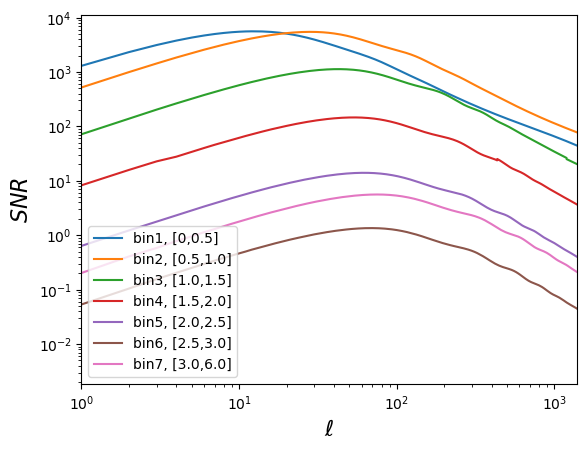

In [ ]:
for i, key1 in enumerate(tracer_keys):
    if i >=2 :
        plt.loglog(result_matrix[i, i, :] /P_sn_LSST[i-2], label = f'{surveys[i-2]}')

plt.legend()
#plt.ylim(0.2,1)
plt.xlim(1,1400)
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel(r'$SNR$',fontsize=16)

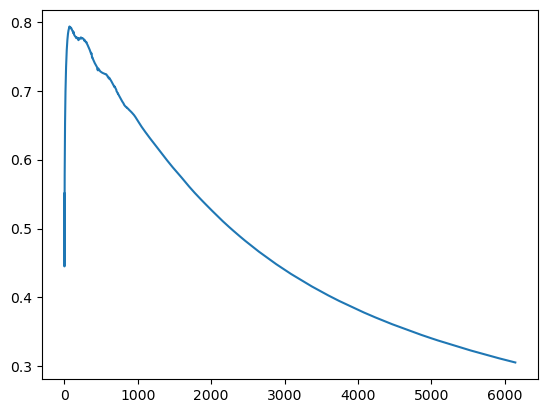

In [ ]:
plt.plot(result_matrix_with_sn[1,0,:]/(result_matrix_with_sn[0,0,:]*result_matrix_with_sn[1,1,:])**0.5)

In [ ]:
#np.save('k_I_LSST_power_matrix_with_sn_new.npy', result_matrix_with_sn)